# Capstone Project (Week 2)

## In this assignment, we'll explore the Covid19 statistics

In [1]:
### import section
# Import libraries with reasons

# Need to use numpy & pandas dataframe
import numpy as np
import pandas as pd
from pandas import DataFrame

### Import matplotlib:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches # needed for waffle Charts

import folium
import seaborn as sns
from PIL import Image # converting images into arrays

from wordcloud import WordCloud
mpl.style.use('ggplot') 

# library to handle requests
import requests 

# To replace multiple strings in one go
import re

# module to convert an address into latitude and longitude values
import geocoder
from geopy.geocoders import Nominatim 

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

from pandas.io.json import json_normalize

from datetime import datetime

#### Initially lets prepare base data 

In [2]:
# Creating the World Master DataFrame with date wise Covid19 count
df_world_master = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv')

print ("Master DataFrame got created with all countries")

Master DataFrame got created with all countries


In [3]:
### Copy the data to another DataFrame, and keep the original as it is
df_world_master2 = df_world_master.copy()

### Remove the unwanted fields
df_world_master2.drop(['weekly_cases', 'weekly_deaths', 'biweekly_cases', 'biweekly_deaths'], axis = 1, inplace = True)

### As we'll use the date function, converting to datetime
df_world_master2['date'] = pd.to_datetime(df_world_master2.date) 

In [4]:
# As we are having daily data for couple of months, it'll keep fortnight data for reporting purpose 

### Keep only 1st and 15th days of the month
df_world_master2 = df_world_master2.iloc[df_world_master2[df_world_master2['date'].dt.day == 1].index].append(df_world_master2.iloc[df_world_master2[df_world_master2['date'].dt.day == 16].index])
df_world_master2.sort_values(['location', 'date'], ascending=[True, True], inplace = True)

In [5]:
### Get the Data only for World
### The master DataFrame is having all countries, including consolidated info for World

df_on_world = pd.DataFrame(df_world_master2[df_world_master2['location'] == 'World'][['date', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths']])
df_on_world.head()

date  new_cases  new_deaths  total_cases  total_deaths
41454 2020-01-01        0.0         0.0         27.0           0.0
41469 2020-01-16        0.0         0.0         61.0           2.0
41485 2020-02-01     2122.0        46.0      11946.0         259.0
41500 2020-02-16     2162.0       142.0      69266.0        1669.0
41514 2020-03-01     1844.0        58.0      87080.0        2979.0

#### Lets explore how the number grows  

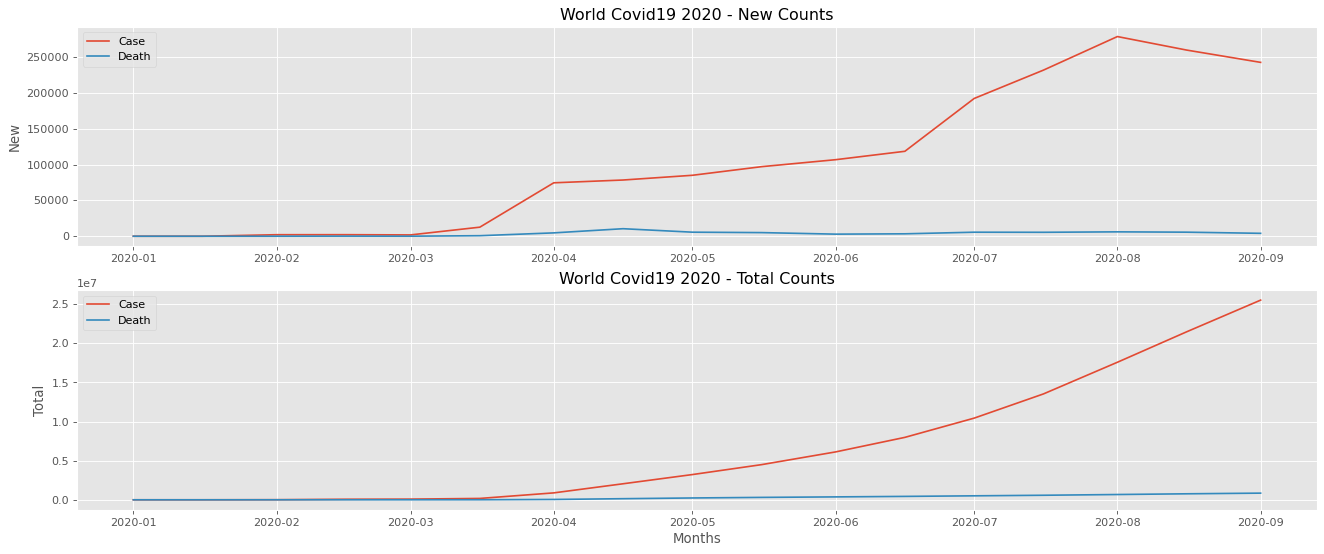

In [6]:
figure(num = None, figsize = (20, 8), dpi = 80, facecolor = 'w', edgecolor = 'k')

plt.subplot(2, 1, 1)
plt.plot(df_on_world['date'], df_on_world['new_cases'], label = "Case")
plt.plot(df_on_world['date'], df_on_world['new_deaths'], label = "Death")
plt.title('World Covid19 2020 - New Counts')
plt.ylabel('New')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_on_world['date'], df_on_world['total_cases'], label = "Case")
plt.plot(df_on_world['date'], df_on_world['total_deaths'], label = "Death")
plt.title('World Covid19 2020 - Total Counts')
plt.xlabel('Months')
plt.ylabel('Total')
plt.legend()

# Display a figure.
plt.show()

#### Now lets' compare between total positive and total death

In [7]:
### Keep the required fields only
df_on_world = df_on_world[['date', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths']]

### Show the number in 'K'
df_on_world['total_cases'] = df_on_world['total_cases'] / 1000
df_on_world['total_deaths'] = df_on_world['total_deaths'] / 1000

Text(0.5, 1.0, 'World Covid19: Comparison between Positive & Deaths (In Thousand)')

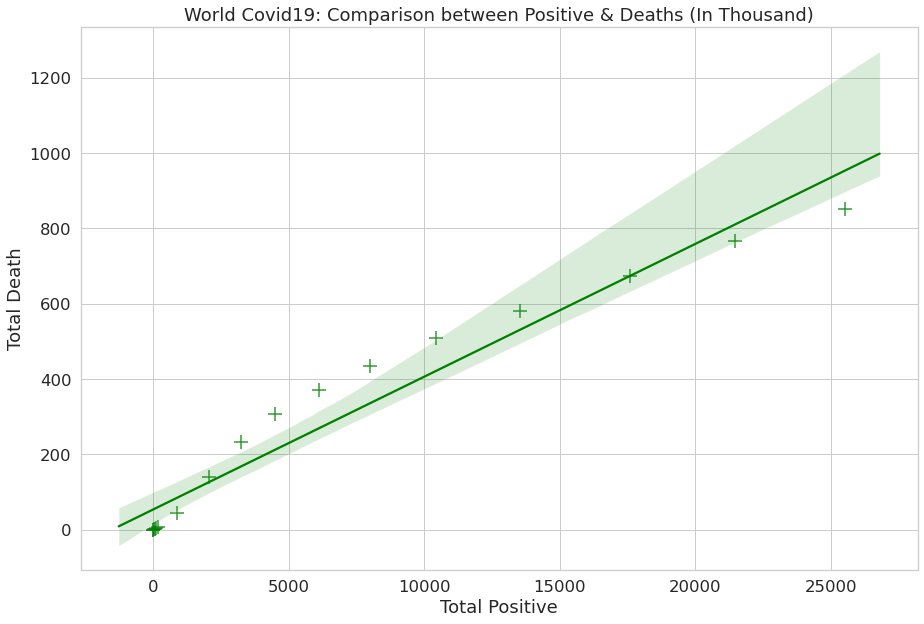

In [8]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

ax = sns.regplot(x='total_cases', y='total_deaths', data=df_on_world, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Total Positive', ylabel='Total Death')
ax.set_title('World Covid19: Comparison between Positive & Deaths (In Thousand)')

#### Now lets consider the highest numbers only

In [9]:
### Extracting the top values

df_world_top = pd.DataFrame()

for affiliate in df_world_master2.sort_values(['date', 'total_cases'], ascending=[True, True]).tail(6)['location'].append(df_world_master2.sort_values(['date', 'total_deaths'], ascending=[True, True]).tail(6)['location'], ignore_index=True).unique():
    df_world_top = df_world_top.append(df_world_master2[df_world_master2["location"] == affiliate])

### Remove the World record
df_world_top.drop(df_world_top[df_world_top['location'] == 'World'].index, inplace = True)

### As the number started growing from Mar2020, lets remove the previous data
df_world_top.drop(df_world_top[df_world_top['date'] < '2020-03-01'].index, inplace = True)

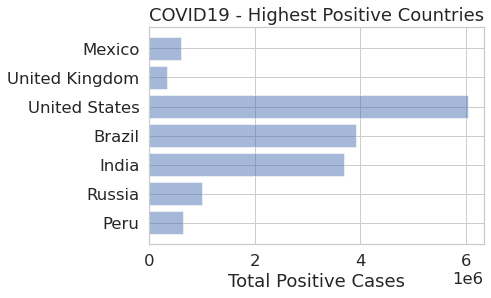

In [10]:
### Horizental Bar

objects = df_world_top['location'].unique()
y_count = np.arange(len(objects))
total_cases = df_world_top[df_world_top['date'] == '2020-09-01']['total_cases']

plt.barh(y_count, total_cases, align='center', alpha=0.5)
plt.yticks(y_count, objects)
plt.xlabel('Total Positive Cases')
plt.title('COVID19 - Highest Positive Countries')
plt.show()

#### How about comparing both the tocal positive & death, along with marker

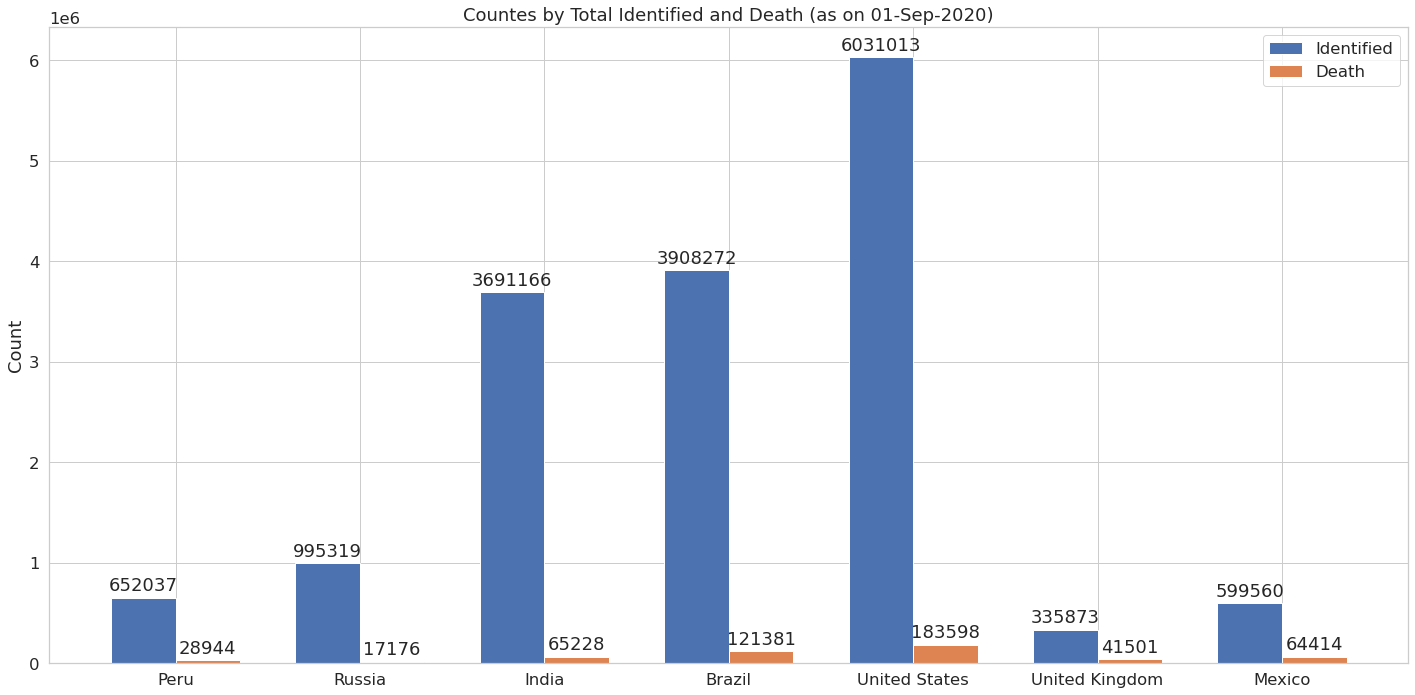

In [11]:
plt.rcParams["figure.figsize"] = 20,10

labels = df_world_top['location'].unique()

## As the data is cumulating, considering the latest date alone
total_cases = df_world_top[df_world_top['date'] == '2020-09-01']['total_cases']
total_deaths = df_world_top[df_world_top['date'] == '2020-09-01']['total_deaths']

x = np.arange(len(labels)) # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, total_cases, width, label='Identified')
rects2 = ax.bar(x + width/2, total_deaths, width, label='Death')

ax.set_ylabel('Count')
ax.set_title('Countes by Total Identified and Death (as on 01-Sep-2020)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = int(rect.get_height())
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

#### Now lets compare between few sepcific countries

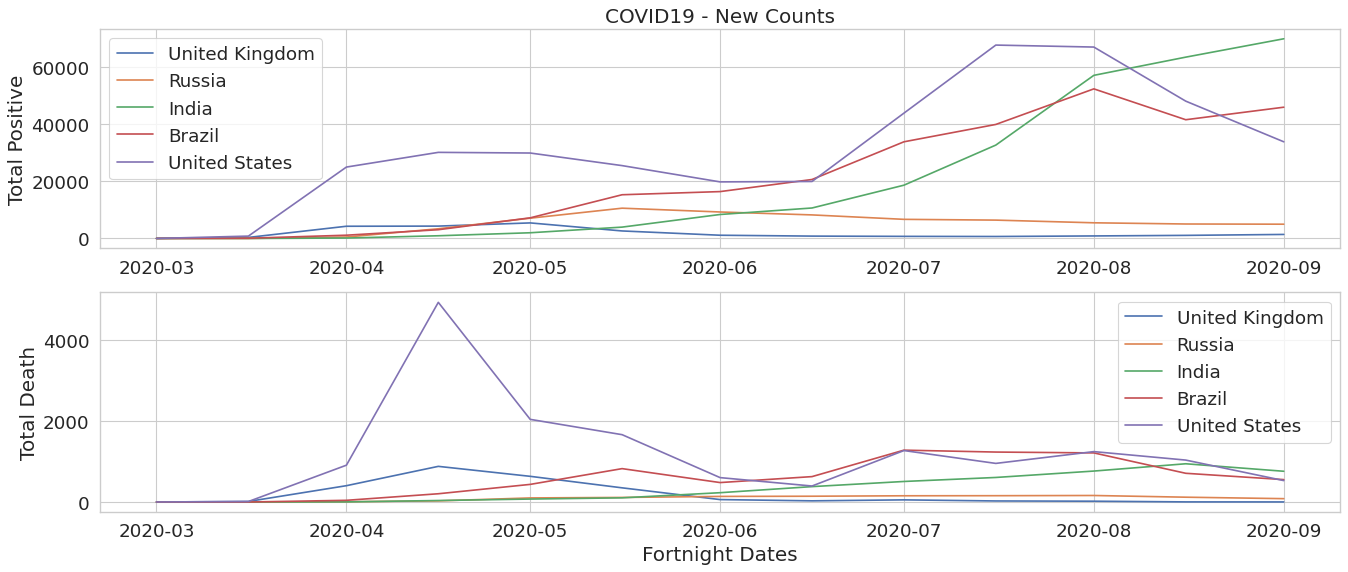

In [12]:
### Comparing the numbers between UK, USA, Russia, Brazil & India

figure(num = None, figsize = (20, 8), dpi = 80, facecolor = 'w', edgecolor = 'k')

plt.subplot(2, 1, 1)
plt.plot(df_world_top[df_world_top['location'] == 'United Kingdom']['date'], df_world_top[df_world_top['location'] == 'United Kingdom']['new_cases'], label = "United Kingdom")
plt.plot(df_world_top[df_world_top['location'] == 'Russia']['date'], df_world_top[df_world_top['location'] == 'Russia']['new_cases'], label = "Russia")
plt.plot(df_world_top[df_world_top['location'] == 'India']['date'], df_world_top[df_world_top['location'] == 'India']['new_cases'], label = "India")
plt.plot(df_world_top[df_world_top['location'] == 'Brazil']['date'], df_world_top[df_world_top['location'] == 'Brazil']['new_cases'], label = "Brazil")
plt.plot(df_world_top[df_world_top['location'] == 'United States']['date'], df_world_top[df_world_top['location'] == 'United States']['new_cases'], label = "United States")
plt.title('COVID19 - New Counts')
plt.ylabel('Total Positive')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_world_top[df_world_top['location'] == 'United Kingdom']['date'], df_world_top[df_world_top['location'] == 'United Kingdom']['new_deaths'], label = "United Kingdom")
plt.plot(df_world_top[df_world_top['location'] == 'Russia']['date'], df_world_top[df_world_top['location'] == 'Russia']['new_deaths'], label = "Russia")
plt.plot(df_world_top[df_world_top['location'] == 'India']['date'], df_world_top[df_world_top['location'] == 'India']['new_deaths'], label = "India")
plt.plot(df_world_top[df_world_top['location'] == 'Brazil']['date'], df_world_top[df_world_top['location'] == 'Brazil']['new_deaths'], label = "Brazil")
plt.plot(df_world_top[df_world_top['location'] == 'United States']['date'], df_world_top[df_world_top['location'] == 'United States']['new_deaths'], label = "United States")
plt.xlabel('Fortnight Dates')
plt.ylabel('Total Death')
plt.legend()

# Display a figure.
plt.show()

#### Now lets see how World looks in folium map

In [13]:
### Remove the 'World' record (where WORLD is an entry as country)
df_world_master2.drop(df_world_master2[df_world_master2['location'] == 'World'].index, inplace = True)

In [14]:
world_geo = r'world_countries.json'

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(df_world_master2[df_world_master2['date'] == '2020-09-01']['total_cases'].min(),
                              df_world_master2[df_world_master2['date'] == '2020-09-01']['total_cases'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# let Folium determine the scale.
world_map = folium.Map(location=[0, 0], zoom_start=2, tiles='Mapbox Bright')
world_map.choropleth(
    geo_data=world_geo,
    data= df_world_master2[df_world_master2['date'] == '2020-09-01'][['location', 'total_cases']],
    columns=['location', 'total_cases'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Covid19 World: Total Positive cases as on 01-Sep-2020',
    reset=True
)
world_map

## Now lets look into USA specific data

In [15]:
# Reading the wikipedia and extracting the info to list
df_usa_state_master = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')

print ("USA Master DataFrame got created")

USA Master DataFrame got created


In [16]:
### Create dataset for US states

### Lets see US state wise status
df_usa_state_master2 = df_usa_state_master[df_usa_state_master['date'] == 20200901][['date', 'state', 'positive', 'negative', 'death']]
df_usa_state_master2.rename({'state': 'code'}, axis=1, inplace=True)

df_usa_state_master2.head()

date code  positive   negative   death
392  20200901   AK    6160.0   368095.0    39.0
393  20200901   AL  127616.0   831304.0  2200.0
394  20200901   AR   61497.0   669528.0   814.0
395  20200901   AS       0.0     1514.0     0.0
396  20200901   AZ  202342.0  1006648.0  5044.0

In [17]:
### As we are having only state code, lets try to get the full state name

### Now get the US state code and update the file to match json file
us_state_name = pd.read_html('https://worldpopulationreview.com/states/state-abbreviations')
df_us_state_name = DataFrame(us_state_name[0])

### Rename the column
df_us_state_name.rename({'State': 'state_name', 'Code': 'code'}, axis=1, inplace=True)

### Delete the unwanted column
df_us_state_name.drop(['Abbreviation'], axis = 1, inplace = True)

df_us_state_name.head()

state_name code
0     Alabama   AL
1      Alaska   AK
2     Arizona   AZ
3    Arkansas   AR
4  California   CA

In [18]:
### Use pandas join function to update the state name based on state code
df_usa_state_master2 = pd.merge(df_usa_state_master2, df_us_state_name, on='code', how='inner')

df_usa_state_master2.head()

date code  positive    negative    death  state_name
0  20200901   AK    6160.0    368095.0     39.0      Alaska
1  20200901   AL  127616.0    831304.0   2200.0     Alabama
2  20200901   AR   61497.0    669528.0    814.0    Arkansas
3  20200901   AZ  202342.0   1006648.0   5044.0     Arizona
4  20200901   CA  707797.0  10762899.0  13018.0  California

In [19]:
usa_geo = r'usa_states.json'

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(df_usa_state_master2['positive'].min(),
                              df_usa_state_master2['positive'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# let Folium determine the scale.
world_map = folium.Map(location=[40, -100], zoom_start=4, tiles='Mapbox Bright')
world_map.choropleth(
    geo_data=usa_geo,
    data=df_usa_state_master2,
    columns=['state_name', 'positive'],
    key_on='feature.properties.NAME',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='USA Covid19',
    reset=True
)
world_map

#### Now lets select the highest death count

In [20]:
### Now lets make the data for 5 highest states
df_usa_state_master2 = df_usa_state_master2[df_usa_state_master2['date'] == 20200901].sort_values(['death'], ascending = [False]).head(5)
df_usa_state_master2.set_index('state_name', inplace = True)

df_usa_state_master2.head()

date code  positive    negative    death
state_name                                              
New York    20200901   NY  435510.0   7904520.0  25331.0
New Jersey  20200901   NJ  192290.0   2666758.0  15953.0
California  20200901   CA  707797.0  10762899.0  13018.0
Texas       20200901   TX  617333.0   4416221.0  12681.0
Florida     20200901   FL  631040.0   4044826.0  11521.0

#### Waffle chart - Compare the death count for these 5 states

In [21]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Comparison between highest 5 death numbers\nTotal number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (df_usa_state_master2.index.values[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        color_val = colormap(float(values_cumsum[i])/total_values)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

Comparison between highest 5 death numbers
Total number of tiles is 400
New York: 129
New Jersey: 81
California: 66
Texas: 65
Florida: 59


<Figure size 1440x720 with 0 Axes>

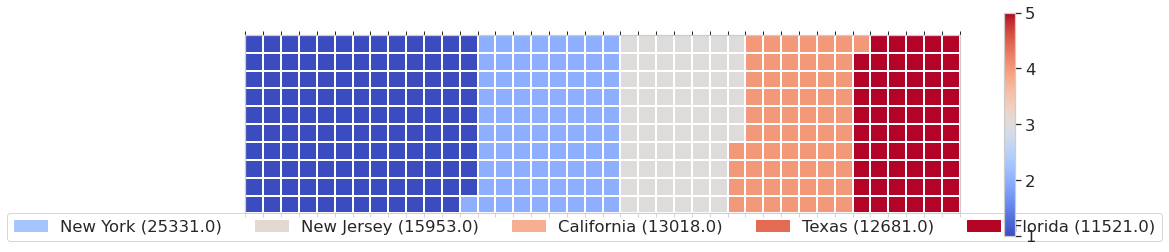

In [22]:
width = 40 # width of chart
height = 10 # height of chart

categories = df_usa_state_master2.index.values # categories
values = df_usa_state_master2['death'] # correponding values of categories

colormap = plt.cm.coolwarm # color map class

### And now let's call our function to create a waffle chart.
create_waffle_chart(categories, values, height, width, colormap)

#### Now, lets get into state & county level

In [23]:
# Reading the wikipedia and extracting the district info to list
df_usa_state_county_master = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [24]:
### Lets explore which state is having highest positive count

df_usa_state_master2.sort_values(['positive'], ascending = [False])

date code  positive    negative    death
state_name                                              
California  20200901   CA  707797.0  10762899.0  13018.0
Florida     20200901   FL  631040.0   4044826.0  11521.0
Texas       20200901   TX  617333.0   4416221.0  12681.0
New York    20200901   NY  435510.0   7904520.0  25331.0
New Jersey  20200901   NJ  192290.0   2666758.0  15953.0

#### As CA is having the highest positive count, lets explore CA and identify counties are most impacted

In [25]:
df_usa_state_county_master[df_usa_state_county_master['state'] == 'California']['county'].unique()

array(['Orange', 'Los Angeles', 'Santa Clara', 'San Francisco',
       'San Diego', 'Humboldt', 'Sacramento', 'Solano', 'Marin', 'Napa',
       'Sonoma', 'Alameda', 'Placer', 'San Mateo', 'Contra Costa', 'Yolo',
       'Fresno', 'Madera', 'Riverside', 'Santa Cruz', 'Shasta',
       'San Joaquin', 'Ventura', 'Stanislaus', 'Tulare', 'San Benito',
       'San Luis Obispo', 'San Bernardino', 'Santa Barbara', 'Nevada',
       'Kern', 'Monterey', 'Mendocino', 'Amador', 'Imperial', 'Butte',
       'El Dorado', 'Siskiyou', 'Yuba', 'Unknown', 'Calaveras', 'Merced',
       'Mono', 'Inyo', 'Sutter', 'Colusa', 'Kings', 'Glenn', 'Tuolumne',
       'Alpine', 'Plumas', 'Del Norte', 'Tehama', 'Lake', 'Mariposa',
       'Trinity', 'Sierra', 'Lassen', 'Modoc'], dtype=object)

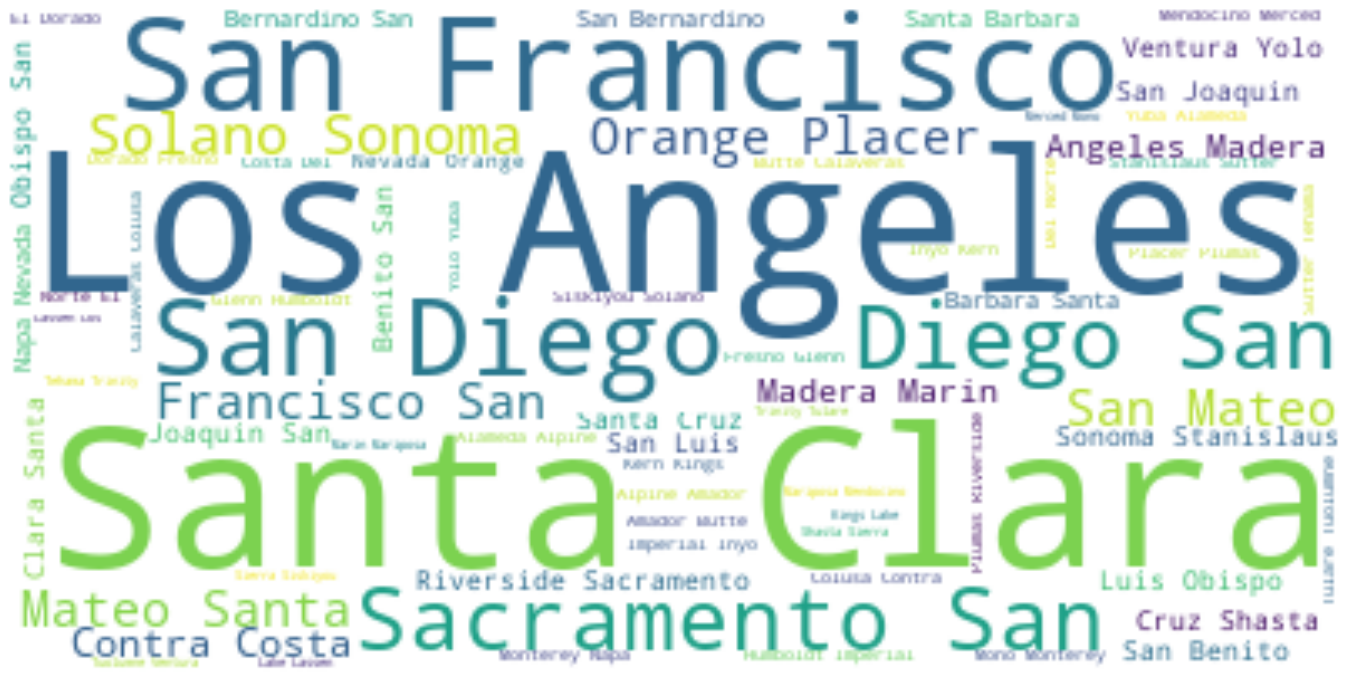

In [26]:
# instantiate a word cloud object

list_of_county = df_usa_state_county_master[df_usa_state_county_master['state'] == 'California']['county'].to_string()

usa_ca = WordCloud(background_color='white', max_words=10000)

# generate the word cloud
usa_ca.generate(list_of_county)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(24) # set width
fig.set_figheight(18) # set height

plt.imshow(usa_ca, interpolation='bilinear')
plt.axis('off')
plt.show()


#### Now lets try to use folium map to track the counties

In [27]:
### Get the Data only for CA, USA
df_usa_ca_county = pd.DataFrame(df_usa_state_county_master[df_usa_state_county_master['state'] == 'California'])
df_usa_ca_county = df_usa_ca_county[df_usa_ca_county['date'] == '2020-09-01']

# Adding Latitude and Longitude columns for Districts and Wards
df_usa_ca_county[['lat', 'lon']] = pd.DataFrame([[0, 0]])

In [28]:
geolocator = Nominatim(user_agent="foursquare_agent")

# Updating the Latitude & Longitude for District DataFrame
for ind1 in df_usa_ca_county.index: 
    address = df_usa_ca_county['county'][ind1] + ', California'
    location = geolocator.geocode(address)

    if isinstance(location, type(None)): 
        df_usa_ca_county['lat'][ind1] = 0
        df_usa_ca_county['lon'][ind1] = 0
    else:
        df_usa_ca_county['lat'][ind1] = location.latitude
        df_usa_ca_county['lon'][ind1] = location.longitude

print ('Updated the latitude & longitude for California states')

/home/debesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/debesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Updated the latitude & longitude for California states


In [29]:
df_usa_ca_county.head()

date     county       state    fips  cases  deaths        lat  \
489381  2020-09-01    Alameda  California  6001.0  18466     257  37.609029   
489382  2020-09-01     Alpine  California  6003.0      2       0  38.589393   
489383  2020-09-01     Amador  California  6005.0    242      15  38.449089   
489384  2020-09-01      Butte  California  6007.0   2146      23  39.651927   
489385  2020-09-01  Calaveras  California  6009.0    257       2  38.255818   

               lon  
489381 -121.899142  
489382 -119.834501  
489383 -120.591102  
489384 -121.585844  
489385 -120.498149

In [30]:
# Creating a function to generate Folium map based on different parameters

def CustomMap (Map, latitudes, longitudes, County, Stat):

    for lat,lng,county, stat in zip(latitudes, longitudes, County, Stat):
        label = '{}: {}'.format(county, stat)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Map) 

In [31]:
### Now lets check the counties for California 
### The Map will also display the county wise Positive (+) or Death (-) cases
Map = folium.Map(location=[36.7783, -119.4179], zoom_start=6)
CustomMap (Map, df_usa_ca_county['lat'], df_usa_ca_county['lon'],df_usa_ca_county['county'], '(+) ' + df_usa_ca_county['cases'].astype(str) + ', (-)' + df_usa_ca_county['deaths'].astype(str))
Map

#### Now lets check the top 20 counties, where cases are more

In [32]:
### Creating a DataFrame for highest 20 counties
df_usa_ca_county_top20 = df_usa_ca_county.sort_values(['cases'], ascending = False).head(20)

In [33]:
df_usa_ca_county_top20

date          county       state    fips   cases  deaths  \
489399  2020-09-01     Los Angeles  California  6037.0  242521    5829   
489413  2020-09-01       Riverside  California  6065.0   53153    1026   
489410  2020-09-01          Orange  California  6059.0   48825     988   
489416  2020-09-01  San Bernardino  California  6071.0   47642     716   
489417  2020-09-01       San Diego  California  6073.0   38934     688   
489395  2020-09-01            Kern  California  6029.0   29459     292   
489390  2020-09-01          Fresno  California  6019.0   25185     290   
489381  2020-09-01         Alameda  California  6001.0   18466     257   
489414  2020-09-01      Sacramento  California  6067.0   18285     296   
489419  2020-09-01     San Joaquin  California  6077.0   17807     330   
489423  2020-09-01     Santa Clara  California  6085.0   17465     249   
489430  2020-09-01      Stanislaus  California  6099.0   14786     262   
489434  2020-09-01          Tulare  California  6107.0   14305     234   
489387  2020-09-01    Contra Costa  California  6013.0   14035     179   
489436  2020-09-01         Ventura  California  6111.0   10866     116   
489393  2020-09-01        Imperial  California  6025.0   10711     293   
489418  2020-09-01   San Francisco  California  6075.0    9547      83   
489421  2020-09-01       San Mateo  California  6081.0    8260     132   
489422  2020-09-01   Santa Barbara  California  6083.0    8164      95   
489404  2020-09-01          Merced  California  6047.0    8081     118   

              lat         lon  
489399  34.053691 -118.242767  
489413  33.953355 -117.396162  
489410  33.750038 -117.870493  
489416  34.825302 -116.083314  
489417  32.717421 -117.162771  
489395  35.314570 -118.753822  
489390  36.739442 -119.784831  
489381  37.609029 -121.899142  
489414  38.581572 -121.494400  
489419  37.937290 -121.277372  
489423  37.233325 -121.684635  
489430  37.550087 -121.050143  
489434  36.251647 -118.852583  
489387  37.903481 -121.917535  
489436  34.445825 -119.077936  
489393  33.030549 -115.359567  
489418  37.779026 -122.419906  
489421  37.496904 -122.333057  
489422  34.422132 -119.702667  
489404  37.164154 -120.767860

In [34]:
# Individual Foursquare ID & Secret
CLIENT_ID = 'TAKDVTLNQKNRLAMYHVJ4GFRSCWBDTTMY2UOEEBZ5KD4HT1G3'   # DR
CLIENT_SECRET = 'AKXUKTLJD0KFMKCTVO11A3F5Y2EHN5BIE3HSDTAXPK1P1IL1'   # DR
VERSION = '20180604'

LIMIT = 75
radius = 2000

In [35]:
# Creating the function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [36]:
# Setting the values to the District wise detail DataFrame

# Creating a new DataFrame to store the County wise results
df_usa_ca_county_venue = pd.DataFrame(columns=['state', 'county', 'venue', 'category', 'lat', 'lon'])

for ind1 in df_usa_ca_county_top20.index: 
    if df_usa_ca_county_top20['lat'][ind1] != 0 and df_usa_ca_county_top20['lon'][ind1] != 0:
        latitude = df_usa_ca_county_top20['lat'][ind1]
        longitude = df_usa_ca_county_top20['lon'][ind1]

        ### Setting the dynamic URL, getting the result and storing into DataFrame
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
        results = requests.get(url).json()
        df_result = json_normalize(results['response']['venues'])
        
        # keep only columns that include venue name, and anything that is associated with location
        req_cols = ['name', 'categories'] + [col for col in df_result.columns if col.startswith('location.')] + ['id']
        df_result_req = df_result.loc[:, req_cols]

        # filter the category for each row
        df_result_req['categories'] = df_result_req.apply(get_category_type, axis=1)

        # clean column names by keeping only last term
        df_result_req.columns = [column.split('.')[-1] for column in df_result_req.columns]

        for ind2 in df_result_req.index: 
            df_usa_ca_county_venue = df_usa_ca_county_venue.append({'state': df_usa_ca_county_top20['state'][ind1], 'county': df_usa_ca_county_top20['county'][ind1], 'venue': df_result_req['name'][ind2], 'category': df_result_req['categories'][ind2], 'lat': df_result_req['lat'][ind2], 'lon':df_result_req['lng'][ind2]}, ignore_index=True)


/home/debesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


#### As we are looking after the Covid19 info, lets try to identify and display the medical support related venues

In [37]:
### Store only medical support related venues
df_usa_ca_county_venue2 = df_usa_ca_county_venue[df_usa_ca_county_venue['category'] == 'Pharmacy']
df_usa_ca_county_venue2 = df_usa_ca_county_venue2.append(df_usa_ca_county_venue[df_usa_ca_county_venue['category'] == 'Medical Center'])
df_usa_ca_county_venue2 = df_usa_ca_county_venue2.append(df_usa_ca_county_venue[df_usa_ca_county_venue['category'] == 'Doctor\'s Office'])
df_usa_ca_county_venue2 = df_usa_ca_county_venue2.append(df_usa_ca_county_venue[df_usa_ca_county_venue['category'] == 'Hospital'])
df_usa_ca_county_venue2 = df_usa_ca_county_venue2.append(df_usa_ca_county_venue[df_usa_ca_county_venue['category'] == 'Medical Lab'])

In [38]:
### lets see what are the category & venues we are having
df_usa_ca_county_venue2.sort_values(['county'])

state         county  \
398   California         Fresno   
394   California         Fresno   
454   California         Fresno   
448   California         Fresno   
437   California         Fresno   
443   California         Fresno   
406   California         Fresno   
15    California    Los Angeles   
1271  California         Merced   
75    California      Riverside   
95    California      Riverside   
98    California      Riverside   
93    California      Riverside   
122   California      Riverside   
129   California      Riverside   
602   California     Sacramento   
598   California     Sacramento   
304   California      San Diego   
1057  California  San Francisco   
1055  California  San Francisco   
1092  California      San Mateo   
1160  California  Santa Barbara   
1216  California  Santa Barbara   
739   California    Santa Clara   
715   California    Santa Clara   
714   California    Santa Clara   
927   California        Ventura   
949   California        Ventura   

                                                 venue         category  \
398                                            LabCorp      Medical Lab   
394                  Community Regional Medical Center         Hospital   
454             Hansen-Smith Family Medicine & Massage  Doctor's Office   
448        Fresno County E.O.C. Health Services Clinic  Doctor's Office   
437                                   Dr. Gloria Traje  Doctor's Office   
443                        Golden Living Center Fresno   Medical Center   
406                                   Free STD Clinics   Medical Center   
15                                        CVS pharmacy         Pharmacy   
1271                               Pinnacle Healthcare   Medical Center   
75                                           Walgreens         Pharmacy   
95                               Central Best Pharmacy         Pharmacy   
98                                  Walgreens Pharmacy         Pharmacy   
93                               Central Medical Group  Doctor's Office   
122                                        Dr. Allison  Doctor's Office   
129            Central Occupational Medicine Providers   Medical Center   
602                                             INNÉOV         Pharmacy   
598                                 Andrew Bloom, PA-C  Doctor's Office   
304                                   STD Test Express      Medical Lab   
1057                                  Free STD Clinics   Medical Center   
1055  Department Of Public Health 3rd Floor Court Room   Medical Center   
1092                                    CCS Tower Road  Doctor's Office   
1160                                      CVS pharmacy         Pharmacy   
1216                                       Better Body         Pharmacy   
739                                           the spot   Medical Center   
715                                    PAMF Pediatrics  Doctor's Office   
714             Kaiser Permanente Radiology Department         Hospital   
927                        Santa Paula Hospital Clinic   Medical Center   
949                                            Dr Lyne  Doctor's Office   

            lat         lon  
398   36.740800 -119.788595  
394   36.742710 -119.784060  
454   36.736179 -119.785653  
448   36.740196 -119.782814  
437   36.742408 -119.787098  
443   36.741889 -119.785326  
406   36.740196 -119.782814  
15    34.053426 -118.242107  
1271  37.065109 -120.835488  
75    33.953062 -117.396073  
95    33.953151 -117.397224  
98    33.952917 -117.396266  
93    33.953134 -117.397216  
122   33.953236 -117.397484  
129   33.953124 -117.399328  
602   38.581727 -121.493363  
598   38.564964 -121.469841  
304   32.716913 -117.163838  
1057  37.771778 -122.424026  
1055  37.778065 -122.418655  
1092  37.513229 -122.333160  
1160  34.422562 -119.703783  
1216  34.421009 -119.701897  
739   37.230104 -121.761839  
715   37.235200 -121.755203  
714   37.234932 -121.754277  
927   34.

#### As Riverside is having maximum venues, we'll use this county for our map 

In [39]:
### Let's try to locate the medical support related venues 

Map = folium.Map(location=[df_usa_ca_county_venue2.loc[df_usa_ca_county_venue2['county'] == 'Riverside']['lat'].mean(), df_usa_ca_county_venue2.loc[df_usa_ca_county_venue2['county'] == 'Riverside']['lon'].mean()], zoom_start=15)
CustomMap (Map,df_usa_ca_county_venue2.loc[df_usa_ca_county_venue2['county'] == 'Riverside']['lat'], df_usa_ca_county_venue2.loc[df_usa_ca_county_venue2['county'] == 'Riverside']['lon'], df_usa_ca_county_venue2.loc[df_usa_ca_county_venue2['county'] == 'Riverside']['venue'], df_usa_ca_county_venue2.loc[df_usa_ca_county_venue2['county'] == 'Riverside']['category'])
Map